# This notebook is dedicated to visualising some data to get insigts

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from model_pipelines.functions import ks_test

In [50]:
events = pd.read_csv('medalion_data_store/bronze/events.csv')
profile = pd.read_csv('medalion_data_store/bronze/profile.csv')
portfolio = pd.read_csv('medalion_data_store/bronze/portfolio.csv')

In [111]:
portfolio

,reward,channels,difficulty,duration,offer_type,ofr_id_short
0,10,"['email', 'mobile', 'social']",10,7,bogo,ofr_A
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,ofr_B
2,0,"['web', 'email', 'mobile']",0,4,informational,ofr_C
3,5,"['web', 'email', 'mobile']",5,7,bogo,ofr_D
4,5,"['web', 'email']",20,10,discount,ofr_E
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,ofr_F
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,ofr_G
7,0,"['email', 'mobile', 'social']",0,3,informational,ofr_H
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,ofr_I
9,2,"['web', 'email', 'mobile']",10,7,discount,ofr_J


In [52]:
# merging evensts and profile
df = events.merge(profile.dropna(), how='left', left_on=['person'], right_on=['id']).drop(columns=['id'])
df = df.merge(portfolio, on=['ofr_id_short'], how='left')

In [55]:
df

,person,event,time,reward_x,ofr_id_short,tag,time_diff,gender,age,became_member_on,income,bec_memb_year_month,age_group,reward_y,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,received,168,NaN,ofr_H,0,NaN,M,33.0,2017-04-21,72000.0,2017-04,Adult,0,"['email', 'mobile', 'social']",0,3,informational
1,0009655768c64bdeb2e877511632db8f,viewed,192,NaN,ofr_H,0,NaN,M,33.0,2017-04-21,72000.0,2017-04,Adult,0,"['email', 'mobile', 'social']",0,3,informational
2,0009655768c64bdeb2e877511632db8f,received,336,NaN,ofr_C,0,168.0,M,33.0,2017-04-21,72000.0,2017-04,Adult,0,"['web', 'email', 'mobile']",0,4,informational
3,0009655768c64bdeb2e877511632db8f,viewed,372,NaN,ofr_C,0,180.0,M,33.0,2017-04-21,72000.0,2017-04,Adult,0,"['web', 'email', 'mobile']",0,4,informational
4,0009655768c64bdeb2e877511632db8f,received,408,NaN,ofr_I,0,72.0,M,33.0,2017-04-21,72000.0,2017-04,Adult,5,"['web', 'email', 'mobile', 'social']",5,5,bogo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,ffff82501cea40309d5fdd7edcca4a07,completed,504,5.0,ofr_D,0,90.0,F,45.0,2016-11-25,62000.0,2016-11,Adult,5,"['web', 'email', 'mobile']",5,7,bogo
167577,ffff82501cea40309d5fdd7edcca4a07,viewed,534,NaN,ofr_D,0,120.0,F,45.0,2016-11-25,62000.0,2016-11,Adult,5,"['web', 'email', 'mobile']",5,7,bogo
167578,ffff82501cea40309d5fdd7edcca4a07,received,576,NaN,ofr_J,2,72.0,F,45.0,2016-11-25,62000.0,2016-11,Adult,2,"['web', 'email', 'mobile']",10,7,discount
167579,ffff82501cea40309d5fdd7edcca4a07,completed,576,2.0,ofr_J,2,72.0,F,45.0,2016-11-25,62000.0,2016-11,Adult,2,"['web', 'email', 'mobile']",10,7,discount


In [154]:
# Grouping the DataFrame by multiple columns and calculating the count and mean for specific columns
offer_event_time = df.groupby(['ofr_id_short', 'gender', 'offer_type', 'difficulty', 'event']).agg(
    cnt=('ofr_id_short', 'count'),
    time_mean=('time', 'mean')
).unstack(level=[4]).reset_index()  # Reset index after unstacking

# Flattening the multi-level column index and removing extra underscores
offer_event_time.columns = ['_'.join(col).strip('_') for col in offer_event_time.columns.to_flat_index()]

# Calculating completion ratio (completed offers / received offers)
offer_event_time['comp_ratio'] = offer_event_time['cnt_completed'] / offer_event_time['cnt_received']

# Calculating view ratio (viewed offers / received offers)
offer_event_time['view_ratio'] = offer_event_time['cnt_viewed'] / offer_event_time['cnt_received']

# Calculating the intensity of completion and viewing
offer_event_time['comp-vie-intensity'] = offer_event_time['comp_ratio'] / offer_event_time['view_ratio']

# Filling NaN values in specific columns with 0
offer_event_time.iloc[:, 2:5] = offer_event_time.iloc[:, 2:5].fillna(0)

# Rounding numerical columns to 3 decimal places
offer_event_time = offer_event_time.round(3)

# Saving the result to a CSV file
# offer_event_time.to_csv('medalion_data_store/silver/offer_event_time.csv', index=False)

# Return the final DataFrame
offer_event_time

,ofr_id_short,gender,offer_type,difficulty,cnt_completed,cnt_received,cnt_viewed,time_mean_completed,time_mean_received,time_mean_viewed,comp_ratio,view_ratio,comp-vie-intensity
0,ofr_A,F,bogo,10,1857.0,2750.0,2364.0,396.481,329.594,353.383,0.675,0.860,0.786
1,ofr_A,M,bogo,10,1741.0,3840.0,3454.0,393.598,330.350,352.214,0.453,0.899,0.504
2,ofr_A,O,bogo,10,59.0,93.0,83.0,362.034,315.097,330.940,0.634,0.892,0.711
3,ofr_B,F,bogo,10,1746.0,2737.0,2623.0,383.842,333.632,351.735,0.638,0.958,0.666
4,ofr_B,M,bogo,10,1519.0,3784.0,3635.0,387.579,335.474,353.959,0.401,0.961,0.418
5,ofr_B,O,bogo,10,45.0,72.0,71.0,367.467,327.333,341.070,0.625,0.986,0.634
6,ofr_C,F,informational,0,0.0,2749.0,1515.0,NaN,335.127,365.303,NaN,0.551,NaN
7,ofr_C,M,informational,0,0.0,3812.0,1902.0,NaN,330.774,358.050,NaN,0.499,NaN
8,ofr_C,O,informational,0,0.0,96.0,70.0,NaN,325.000,342.343,NaN,0.729,NaN
9,ofr_D,F,bogo,5,1999.0,2767.0,1544.0,400.355,330.822,359.332,0.722,0.558,1.295


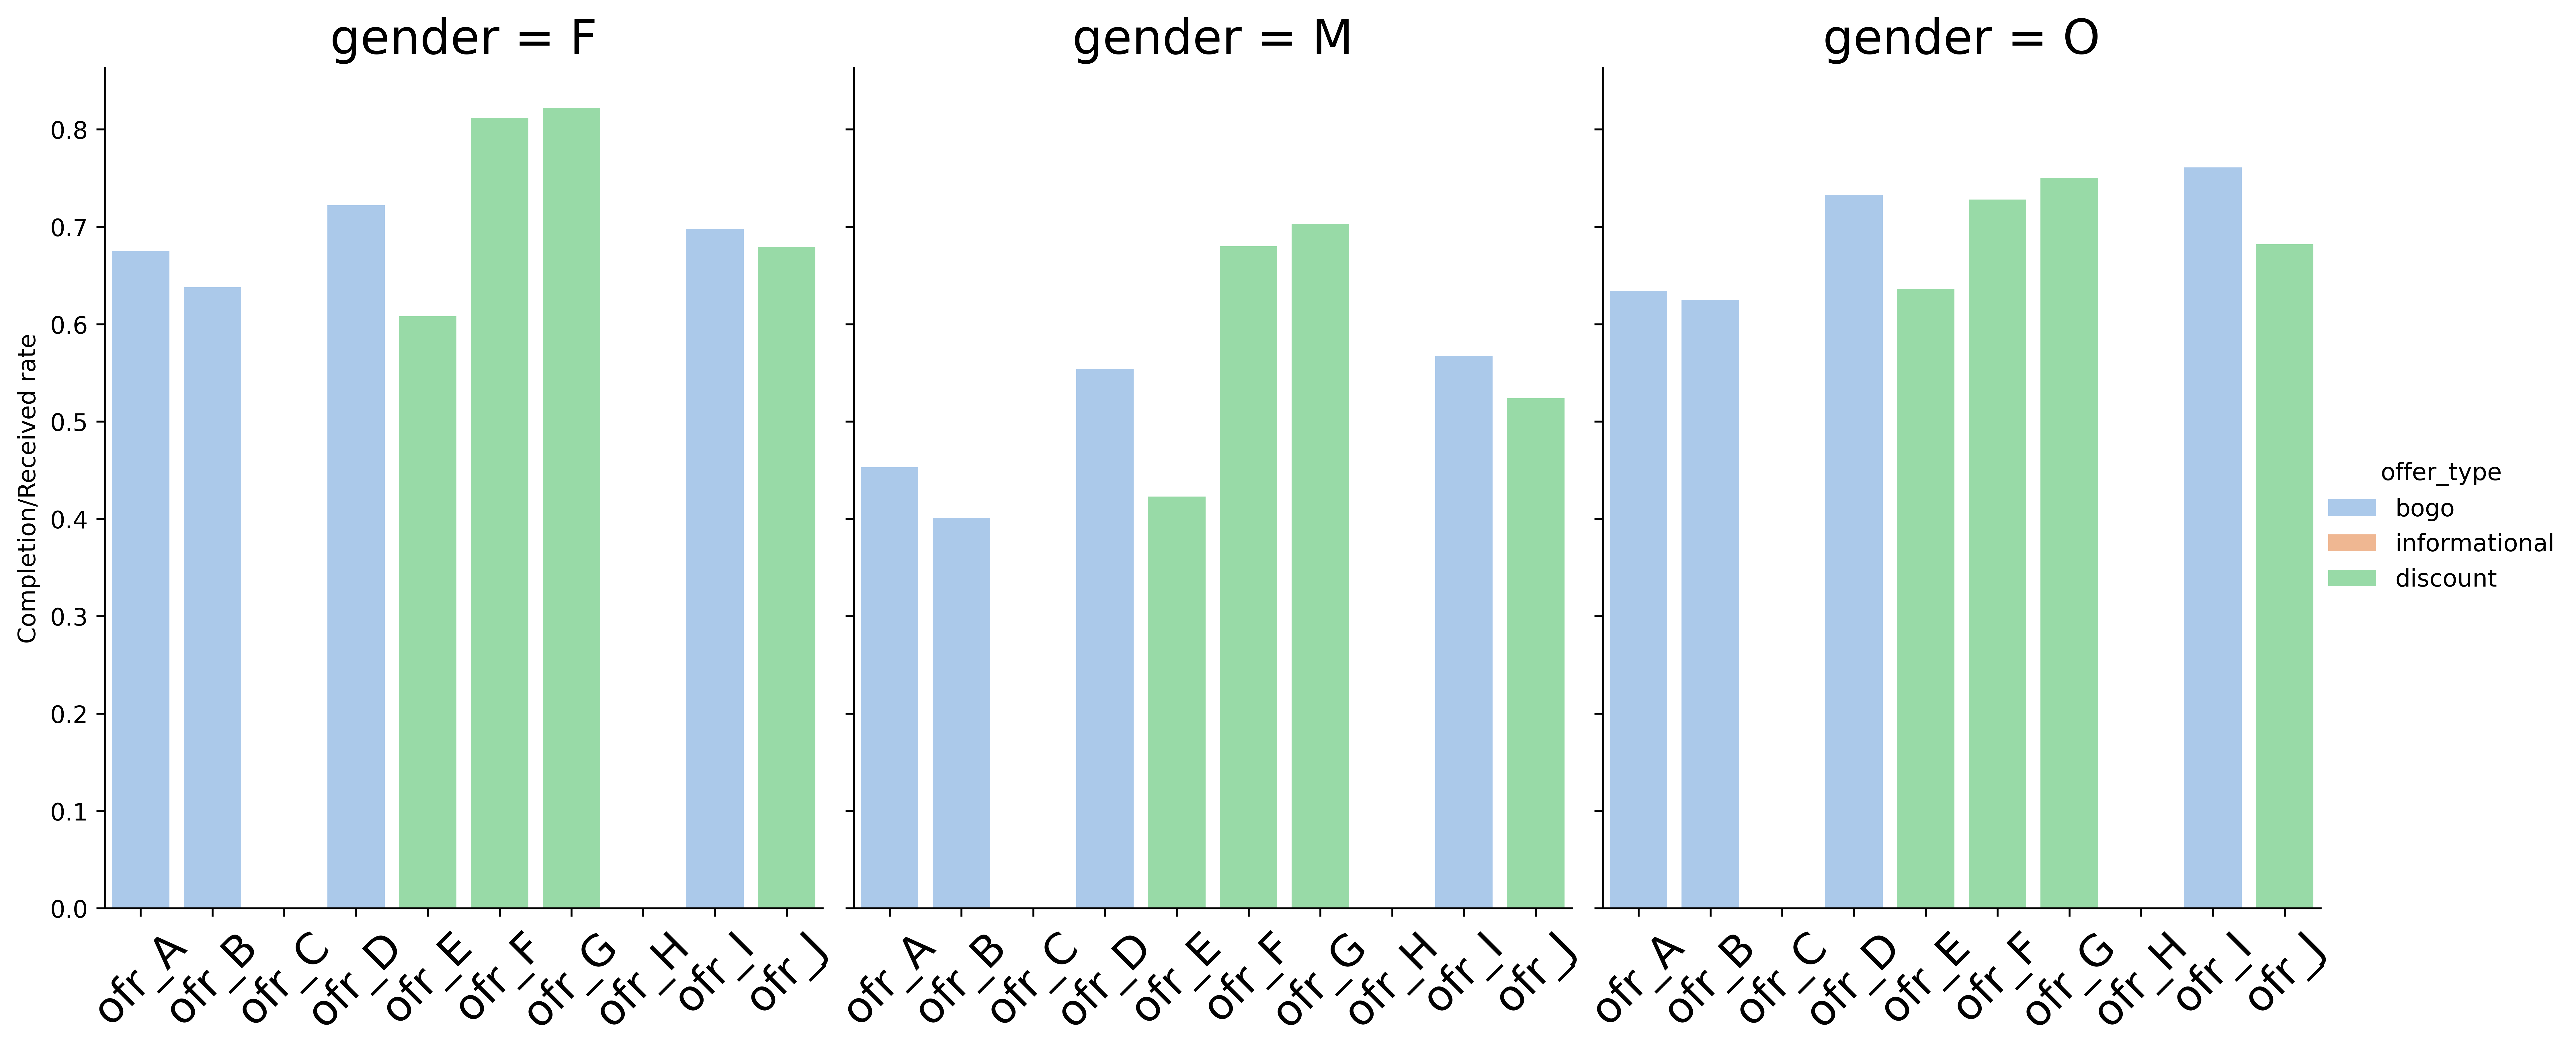

In [155]:
# Create the plot
ax = sns.catplot(
    data=offer_event_time,
    kind="bar",
    y='comp_ratio',
    x='ofr_id_short',
    hue='offer_type',
    col='gender',
    palette='pastel'
)

# Rotate x-axis labels safely
for a in ax.axes.flat:
    plt.setp(a.xaxis.get_majorticklabels(), rotation=45, fontsize=18)
    a.set_title(a.get_title(), fontsize=20)

# Set y-axis label
ax.set_ylabels('Completion/Received rate')
ax.set_xlabels('')

# Adjust figure size and resolution
ax.figure.set_size_inches(15, 6)
ax.figure.set_dpi(600)

# Show the plot
plt.show()

ax.savefig('figs/gender_ofr_ratio.png')


In [151]:
# Grouping the DataFrame by multiple columns and calculating the count and mean for specific columns
offer_event_time = df.groupby(['ofr_id_short', 'age_group', 'offer_type', 'difficulty', 'event']).agg(
    cnt=('ofr_id_short', 'count'),
    time_mean=('time', 'mean')
).unstack(level=[4]).reset_index()  # Reset index after unstacking

# Flattening the multi-level column index and removing extra underscores
offer_event_time.columns = ['_'.join(col).strip('_') for col in offer_event_time.columns.to_flat_index()]

# Calculating completion ratio (completed offers / received offers)
offer_event_time['comp_ratio'] = offer_event_time['cnt_completed'] / offer_event_time['cnt_received']

# Calculating view ratio (viewed offers / received offers)
offer_event_time['view_ratio'] = offer_event_time['cnt_viewed'] / offer_event_time['cnt_received']

# Calculating the intensity of completion and viewing
offer_event_time['comp-vie-intensity'] = offer_event_time['comp_ratio'] / offer_event_time['view_ratio']

# Filling NaN values in specific columns with 0
offer_event_time.iloc[:, 2:5] = offer_event_time.iloc[:, 2:5].fillna(0)

# Rounding numerical columns to 3 decimal places
offer_event_time = offer_event_time.round(3)

# Saving the result to a CSV file
# offer_event_time.to_csv('medalion_data_store/silver/offer_event_time.csv', index=False)

# Return the final DataFrame
offer_event_time

,ofr_id_short,age_group,offer_type,difficulty,cnt_completed,cnt_received,cnt_viewed,time_mean_completed,time_mean_received,time_mean_viewed,comp_ratio,view_ratio,comp-vie-intensity
0,ofr_A,Adult,bogo,10,714.0,1560.0,1470.0,387.244,324.800,344.159,0.458,0.942,0.486
1,ofr_A,Middle,bogo,10,1760.0,2945.0,2488.0,398.212,332.153,355.941,0.598,0.845,0.707
2,ofr_A,Senior,bogo,10,1029.0,1740.0,1523.0,394.140,329.834,354.319,0.591,0.875,0.676
3,ofr_A,Young,bogo,10,154.0,438.0,420.0,389.377,332.055,353.071,0.352,0.959,0.367
4,ofr_B,Adult,bogo,10,617.0,1475.0,1418.0,392.382,335.235,353.031,0.418,0.961,0.435
5,ofr_B,Middle,bogo,10,1554.0,2854.0,2735.0,381.884,334.478,353.544,0.544,0.958,0.568
6,ofr_B,Senior,bogo,10,1002.0,1788.0,1722.0,389.108,337.584,354.683,0.560,0.963,0.582
7,ofr_B,Young,bogo,10,137.0,476.0,454.0,365.124,322.437,341.749,0.288,0.954,0.302
8,ofr_C,Adult,informational,0,0.0,1518.0,729.0,NaN,336.158,359.045,NaN,0.480,NaN
9,ofr_C,Middle,informational,0,0.0,2893.0,1621.0,NaN,333.818,361.473,NaN,0.560,NaN


In [152]:
# Create the plot
ax = sns.catplot(
    data=offer_event_time,
    kind="bar",
    y='comp_ratio',
    x='ofr_id_short',
    hue='offer_type',
    col='age_group',
    palette='pastel'
)

# Rotate x-axis labels safely
for a in ax.axes.flat:
    plt.setp(a.xaxis.get_majorticklabels(), rotation=45, fontsize=20)
    a.set_title(a.get_title(), fontsize=22)

# Set y-axis label
# Set y-axis label
ax.set_ylabels('Completion/Received rate')
ax.set_xlabels('')

# Adjust figure size and resolution
ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(600)

# Show the plot
plt.show()

ax.savefig('figs/age_ofr_ratio.png')